# Numerical Data Only EDA, Preprocessing, and Feature Engineering
This notebook is going to focus only on the numeric data, including categorical numeric data, starting with columns that have no missing data, then adding in columns that are cleaned of their nulls, and then engineering the features. I am keeping my features column list as a dataframe to import over to 03_Model_Prep_and_Submissions because I want to use the features dataframe as a reference for how the test data should look when preparing to run the model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

#### Model 1
This first model is as is, with no EDA or anything. Going to use all the columns for a baseline and run the tests and evaluations to see how the model does.

In [2]:
# https://stackoverflow.com/questions/57777635/how-to-deal-with-nan-values-in-pandas-from-csv-file for help with importing NA
# Using the na_filter=False because I know from cleaning the data that all cells are filled correctly.
df_train_v1 = pd.read_csv('../datasets/cleaned_data/clean_train_v1.csv', na_filter=False)
feat_v1 = pd.read_csv('../datasets/cleaned_data/feat_v1.csv')

feat_v1.head()

,Id,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,1st Flr SF,2nd Flr SF,...,Fireplaces,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold
0,109,533352170,60,13517,6,8,1976,2005,725,754,...,0,0,44,0,0,0,0,0,3,2010
1,544,531379050,60,11492,7,5,1996,1997,913,1209,...,1,0,74,0,0,0,0,0,4,2009
2,153,535304180,20,7922,5,7,1953,2007,1057,0,...,0,0,52,0,0,0,0,0,1,2010
3,318,916386060,60,9802,5,5,2006,2007,744,700,...,0,100,0,0,0,0,0,0,4,2010
4,255,906425045,50,14235,6,8,1900,1993,831,614,...,0,0,59,0,0,0,0,0,3,2010


In [3]:
df_train_v1.isnull().sum().sum()

0

In [4]:
df_train_v1.shape

(2051, 81)

In [5]:
X_v1 = df_train_v1[feat_v1.columns]
y_v1 = df_train_v1['SalePrice']

lr_v1 = LinearRegression()

X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(X_v1, y_v1, random_state=42)

In [6]:
cross_val_score(lr_v1,X_train_v1, y_train_v1).mean()

0.7684342501511396

For my first submission, I am just submitting this as is, so no EDA just yet. This will be a baseline to see what happens. EDA and feature engineering will take place below. Features being used are all of the feat_v1 columns. I am only running the cross_val_score for a benchmark going forward.

#### Model 2
Here I will do EDA and feature engineering on the above dataset and see if we can do better. I will also address the 'MS SubClass' feature and see how it can be used.

In [7]:
feat_v2 = feat_v1.drop(columns=['PID'])

In [8]:
feat_v2['MS SubClass'].describe()
# 'MS SubClass' does not have any meaning as it goes up the scale, it is purely categorical
# Will create dummies and compare to 'SalePrice' in the main dataframe to see if it is worth continuing to look at

count    2051.000000
mean       57.008776
std        42.824223
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MS SubClass, dtype: float64

In [9]:
df_train_v2 = pd.get_dummies(df_train_v1, columns=['MS SubClass'], drop_first=True)
df_train_v2.head()

,Id,PID,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190
0,109,533352170,RL,0.0,13517,1,NA,1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
1,544,531379050,RL,43.0,11492,1,NA,1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
2,153,535304180,RL,68.0,7922,1,NA,0,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
3,318,916386060,RL,73.0,9802,1,NA,0,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0
4,255,906425045,RL,82.0,14235,1,NA,1,Lvl,AllPub,...,0,0,0,0,0,0,0,0,0,0


In [10]:
ms_sub_vs_price = df_train_v2[['SalePrice']+[_ for _ in df_train_v2 if 'MS SubClass' in _]]

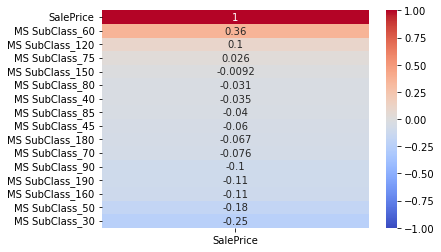

In [11]:
sns.heatmap(ms_sub_vs_price.corr().sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

There is not a whole lot of correlation showing. MS SubClass 60 is newer 2-story houses, so it makes sense those typically are more expensive. Alternatively, MS Subclass 30 are houses built prior to 1945, making them old and logically cheaper. Since these are dummies, we can't really use them for feature engineering. Additionally, it looks like the year it was built had is what drove the stronger correlations, which is a column we already have. Thus, I am dropping this feature from my features list.

In [12]:
feat_v2.drop(columns='MS SubClass', inplace=True)
df_train_v2 = df_train_v1
# Resetting the dataframe and adding 'MS SubClass' back in.

In [13]:
feat_v2.columns

Index(['Id', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold'],
      dtype='object')

In [14]:
df_train_v2.shape

(2051, 81)

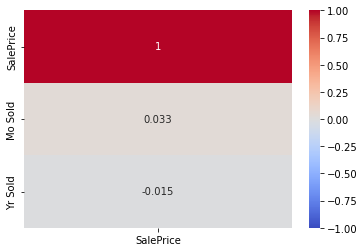

In [15]:
# Does the month and year that it was sold hold any sway?
sns.heatmap(df_train_v2[['SalePrice','Mo Sold','Yr Sold']].corr().sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

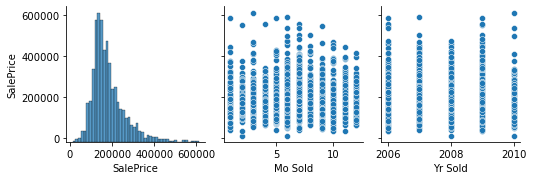

In [16]:
# Used lesson-model-workflow starter-code notebook as guide.
sns.pairplot(df_train_v2, x_vars = ['SalePrice','Mo Sold','Yr Sold'], y_vars=['SalePrice']);

In [17]:
# Is there a correlation between year sold and year built and/or remodeled?
# Also between year built and remodeled, if at all?
df_train_v2['Yr Sold Year Remod/Add'] = df_train_v2['Yr Sold'] * df_train_v2['Year Remod/Add']
df_train_v2['Yr Sold Year Built'] = df_train_v2['Yr Sold'] * df_train_v2['Year Built']
df_train_v2['Year Built Year Remod/Add'] = df_train_v2['Year Built'] * df_train_v2['Year Remod/Add']

In [18]:
year_comp = df_train_v2[['SalePrice','Year Remod/Add', 'Year Built', 'Yr Sold Year Remod/Add',
                         'Yr Sold Year Built', 'Year Built Year Remod/Add']]

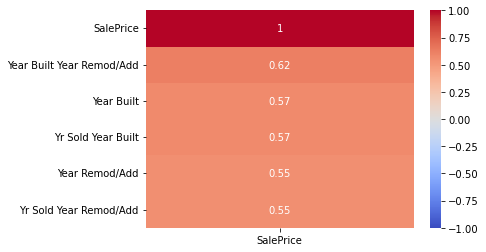

In [19]:
sns.heatmap(year_comp.corr().sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

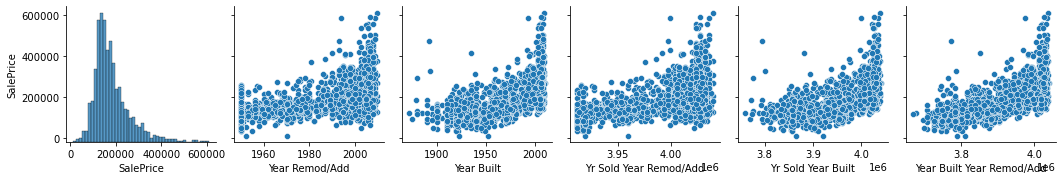

In [20]:
sns.pairplot(year_comp, x_vars=year_comp.columns, y_vars='SalePrice');

Contrary to what I thought, price is not really affected by the year or month. More houses were sold in the summer months, but the prices did not skew one way or the other. As for year, I though that houses sold after the housing bubble bust would be lower, but there is no strong correlation. 2010 has a little more clustering towards the lower end of 'SalePrice', but the other 4 years have are pretty consistent. Both columns can be dropped in my opinion since there is no correlation.


What is interesting to look is the comparisons between year built, year remodeled, and year sold. All of them have strong correlations, but the year sold is still the least important, so that can be pulled. The other correlations are stronger with the stongest being 'Year Built Year Remod/Add' and having the tightest scatterplots. It makes sense too, since we are multiplying the two columns and a house that is remodeled or had an add on, even if it wasn't that old, would sell for more. I am going to keep the 'Year Built Year Remod/Add' column and add it to my features. I am getting rid of 'Mo Sold', 'Yr Sold', 'Year Built' and 'Year Remod/Add' from my features and removing 'Yr Sold Year Remod/Add' and 'Yr Sold Year Built' columns from the data frame.

In [21]:
df_train_v2.drop(columns=['Yr Sold Year Remod/Add', 'Yr Sold Year Built'], inplace=True)

In [22]:
feat_v2.drop(columns=['Mo Sold', 'Yr Sold', 'Year Built', 'Year Remod/Add'], inplace=True)

In [23]:
feat_v2.columns

Index(['Id', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val'],
      dtype='object')

In [24]:
# Adding 'Year Built Year Remod/Add' to my features dataframe.
feat_v2 = pd.merge(feat_v2, df_train_v2[['Year Built Year Remod/Add', 'Id']], on='Id', how='left')

Going to run a couple of quick score evaluations prior to working on the square footage of rooms and the number and types of rooms to see how the model is looking. I will be exporting this data to 03_Model_Prep_and_Submissions to see how it does on Kaggle. 

In [25]:
X_v2 = df_train_v2[feat_v2.columns]
y_v2 = df_train_v2['SalePrice']

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, random_state=42)

In [26]:
lr_v2 = LinearRegression()
lr_v2.fit(X_train_v2, y_train_v2)

LinearRegression()

In [27]:
lr_v2.score(X_train_v2, y_train_v2)

0.8015974695490211

In [28]:
lr_v2.score(X_test_v2, y_test_v2)

0.8349860610301522

In [29]:
cross_val_score(lr_v2, X_train_v2, y_train_v2).mean()

0.764881143888595

The bias seems pretty good, however the variance seems a little high. That may be because of the test sample though, so I am going to rerun with a different random_state below twice, just to make sure.

In [30]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, random_state=2010)

In [31]:
lr_v2.score(X_train_v2, y_train_v2)

0.8052649484794963

In [32]:
lr_v2.score(X_test_v2, y_test_v2)

0.8246274608361206

In [33]:
cross_val_score(lr_v2, X_train_v2, y_train_v2).mean()

0.7687684524347904

In [34]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, random_state=2014)

In [35]:
lr_v2.score(X_train_v2, y_train_v2)

0.8226594943578085

In [36]:
lr_v2.score(X_test_v2, y_test_v2)

0.7680689945123855

In [37]:
cross_val_score(lr_v2, X_train_v2, y_train_v2).mean()

0.7912242632641806

Going forward I will be using the random state of 2010. The variance is still high, so I will be looking to see what the outliers can tell me to try to reduce the variance in the model. First I am going to submit what this model for a score to see if it is better than my previous submission.

In [38]:
feat_v2.to_csv('../datasets/ready_for_model/feat_v2.csv', index=False)
df_train_v2.to_csv('../datasets/ready_for_model/clean_train_v2.csv', index=False)

In [39]:
preds_v2 = lr_v2.predict(X_test_v2)
residuals_v2 = y_test_v2 - preds_v2

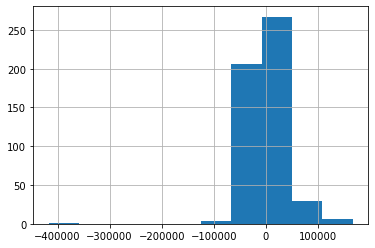

In [40]:
residuals_v2.hist();

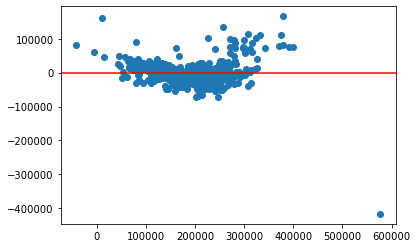

In [41]:
plt.axhline(0, color='r')
plt.scatter(preds_v2, residuals_v2);

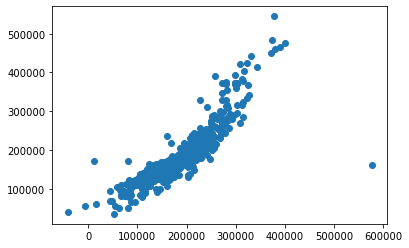

In [42]:
plt.scatter(preds_v2, y_test_v2);

In [43]:
pd.DataFrame(preds_v2)[pd.DataFrame(preds_v2)[0] > 500_000]

,0
505,577231.053825


In [44]:
pd.DataFrame(y_test_v2,).iloc[505]

SalePrice    160000
Name: 960, dtype: int64

There appears to be one major outlier that is throwing everything off. Index number 960 is the main culprit.

In [45]:
# https://blog.softhints.com/pandas-display-all-columns-and-show-more-rows/ for help showing all rows
with pd.option_context('display.max_columns', 90):
    display(df_train_v2.iloc[[958,959,960,961,962], :])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Year Built Year Remod/Add
958,1458,907254020,60,RL,73.0,9066,1,NA,1,Lvl,AllPub,Inside,1,CollgCr,Norm,Norm,1Fam,2Story,8,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,320.0,4,3,PConc,4,3,2,6,668.0,1,0.0,336.0,1004.0,GasA,5,1,SBrkr,1004,848,0,1852,0.0,0.0,2,1,3,1,4,7,7,2,3,Attchd,1999.0,Fin,3.0,660.0,3,3,1.0,224,106,0,0,0,0,0,GdPrv,NA,0,12,2008,WD,230000,3998000
959,281,908203100,20,RL,64.0,6410,1,NA,0,HLS,AllPub,Inside,1,Edwards,Norm,Norm,1Fam,1Story,4,5,1958,1958,Hip,CompShg,WdShing,Wd Shng,None,0.0,3,3,CBlock,3,3,1,1,0.0,1,0.0,960.0,960.0,GasA,5,1,SBrkr,960,0,0,960,0.0,0.0,1,0,3,1,3,5,7,0,0,NA,0.0,NA,0.0,0.0,0,0,1.0,0,0,0,0,0,0,0,MnPrv,NA,0,5,2010,WD,90000,3833764
960,1499,908154235,60,RL,313.0,63887,1,NA,3,Bnk,AllPub,Corner,1,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,5,3,PConc,5,3,4,6,5644.0,1,0.0,466.0,6110.0,GasA,5,1,SBrkr,4692,950,0,5642,2.0,0.0,2,1,3,1,5,12,7,3,4,Attchd,2008.0,Fin,2.0,1418.0,3,3,1.0,214,292,0,0,0,480,3,NA,NA,0,1,2008,New,160000,4032064
961,2298,923230180,85,RL,54.0,7244,1,NA,0,Lvl,AllPub,Inside,1,Mitchel,Norm,Norm,1Fam,SFoyer,5,7,1970,1970,Gable,CompShg,VinylSd,VinylSd,None,0.0,3,4,CBlock,4,3,3,5,619.0,1,0.0,149.0,768.0,GasA,5,1,SBrkr,768,0,0,768,1.0,0.0,1,0,2,1,3,5,7,0,0,Detchd,1987.0,Unf,2.0,624.0,3,3,1.0,104,0,0,0,0,0,0,NA,NA,0,4,2007,WD,129500,3880900
962,2580,535180020,20,RL,72.0,10152,1,NA,0,Lvl,AllPub,Inside,1,NAmes,Norm,Norm,1Fam,1Story,6,6,1956,1994,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,3,4,914.0,1,0.0,210.0,1124.0,GasA,5,1,SBrkr,1124,0,0,1124,1.0,0.0,1,0,3,1,3,6,7,1,3,Attchd,1956.0,Fin,1.0,353.0,3,3,1.0,0,211,180,0,142,0,0,NA,NA,0,5,2006,WD,153000,3900264


Index 960, which is Id 1499, has a massive lot area, 10 in overall quality, and the square footage for everything is comparatively very large. Despite it's massive size and being recently built, the house sold for only \$160,000. Considering that the square footages seem to be consistant with eachother, the price appears to be the only real issue. I am deleting this outlier.

In [46]:
df_train_v2.drop(960, inplace=True)

In [47]:
X_v2 = df_train_v2[feat_v2.columns]
y_v2 = df_train_v2['SalePrice']

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X_v2, y_v2, random_state=2010)

lr_v2 = LinearRegression()
lr_v2.fit(X_train_v2, y_train_v2)

LinearRegression()

In [48]:
lr_v2.score(X_train_v2, y_train_v2)

0.8297672293372812

In [49]:
lr_v2.score(X_test_v2, y_test_v2)

0.8275553656144805

In [50]:
cross_val_score(lr_v2, X_train_v2, y_train_v2).mean()

0.7917414863949482

In [51]:
preds_v2 = lr_v2.predict(X_test_v2)
residuals_v2 = y_test_v2 - preds_v2

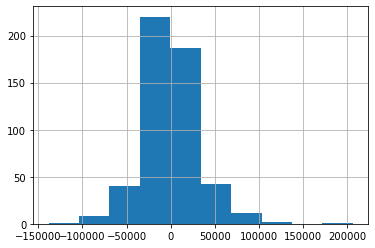

In [52]:
residuals_v2.hist();

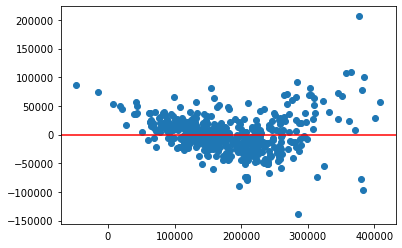

In [53]:
plt.axhline(0, color='r')
plt.scatter(preds_v2, residuals_v2);

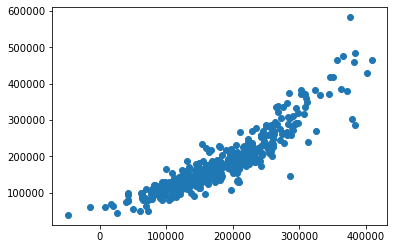

In [54]:
plt.scatter(preds_v2, y_test_v2);

In [55]:
df_train_v2.to_csv('../datasets/ready_for_model/clean_train_v2_1.csv', index=False)

#### Model 3
Deleting the outlier did help make it some, making it my best submission so far. Now that I have started narrowing things down some, I am going to bring in the rest of the numeric features that originally had nulls in them. The columns that were originally nulls are coming from the data cleaning notebook.

In [56]:
df_train_v3 = df_train_v2
# Going forward, only editing the 3rd version to go with this being my 3rd model

In [57]:
was_null_df = pd.read_csv('../datasets/cleaned_data/num_was_null_feat.csv')
was_null_df.head()

,Lot Frontage,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
0,0.0,289.0,533.0,0.0,192.0,725.0,0.0,0.0,1976.0,2.0,475.0
1,43.0,132.0,637.0,0.0,276.0,913.0,1.0,0.0,1997.0,2.0,559.0
2,68.0,0.0,731.0,0.0,326.0,1057.0,1.0,0.0,1953.0,1.0,246.0
3,73.0,0.0,0.0,0.0,384.0,384.0,0.0,0.0,2007.0,2.0,400.0
4,82.0,0.0,0.0,0.0,676.0,676.0,0.0,0.0,1957.0,2.0,484.0


In [58]:
was_null_df.columns

Index(['Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area'],
      dtype='object')

In [59]:
feat_v2.columns

Index(['Id', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Year Built Year Remod/Add'],
      dtype='object')

In [60]:
feat_v3 = df_train_v3[['Id', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Year Built Year Remod/Add', 'Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area']]
feat_v3.head()

,Id,Lot Area,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,...,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
0,109,13517,6,8,725,754,0,1479,2,1,...,289.0,533.0,0.0,192.0,725.0,0.0,0.0,1976.0,2.0,475.0
1,544,11492,7,5,913,1209,0,2122,2,1,...,132.0,637.0,0.0,276.0,913.0,1.0,0.0,1997.0,2.0,559.0
2,153,7922,5,7,1057,0,0,1057,1,0,...,0.0,731.0,0.0,326.0,1057.0,1.0,0.0,1953.0,1.0,246.0
3,318,9802,5,5,744,700,0,1444,2,1,...,0.0,0.0,0.0,384.0,384.0,0.0,0.0,2007.0,2.0,400.0
4,255,14235,6,8,831,614,0,1445,2,0,...,0.0,0.0,0.0,676.0,676.0,0.0,0.0,1957.0,2.0,484.0


I am now going to look at the square footage columns and see if some of them can be dropped.

In [61]:
feat_v3.columns

Index(['Id', 'Lot Area', 'Overall Qual', 'Overall Cond', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
       '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Year Built Year Remod/Add', 'Lot Frontage', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area'],
      dtype='object')

In [62]:
feat_v3_sqft_cols = ['Lot Area', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF',
                     'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Lot Frontage',
                     'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area']

In [63]:
sqft_corr = df_train_v3[feat_v3_sqft_cols + ['SalePrice']].corr()

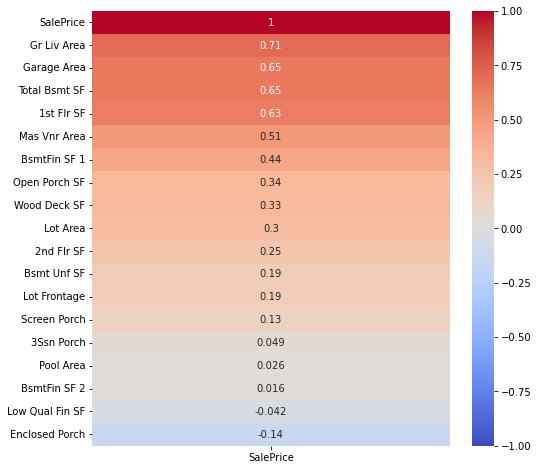

In [64]:
plt.figure(figsize=(8,8))
sns.heatmap(sqft_corr.sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

Looking at just the correlation above, the most import square footages appear to be the ones having to do with overall square footages for above ground, basement, and garage. However, I am curious as to how it would look if we did a polynomial transformation on this and see what that looks like when run with Lasso and Ridge models.

In [65]:
# lari1 to represent Lasso and Ridge version 1
X_lari1 = df_train_v3[feat_v3_sqft_cols]
y_lari1 = df_train_v3['SalePrice']

In [66]:
# From regularization starter-code notebook. 
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
poly_sqft_feats = poly.fit_transform(X_lari1)

In [67]:
poly.get_feature_names(X_lari1.columns)

['Lot Area',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Lot Frontage',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Garage Area',
 'Lot Area^2',
 'Lot Area 1st Flr SF',
 'Lot Area 2nd Flr SF',
 'Lot Area Low Qual Fin SF',
 'Lot Area Gr Liv Area',
 'Lot Area Wood Deck SF',
 'Lot Area Open Porch SF',
 'Lot Area Enclosed Porch',
 'Lot Area 3Ssn Porch',
 'Lot Area Screen Porch',
 'Lot Area Pool Area',
 'Lot Area Lot Frontage',
 'Lot Area Mas Vnr Area',
 'Lot Area BsmtFin SF 1',
 'Lot Area BsmtFin SF 2',
 'Lot Area Bsmt Unf SF',
 'Lot Area Total Bsmt SF',
 'Lot Area Garage Area',
 '1st Flr SF^2',
 '1st Flr SF 2nd Flr SF',
 '1st Flr SF Low Qual Fin SF',
 '1st Flr SF Gr Liv Area',
 '1st Flr SF Wood Deck SF',
 '1st Flr SF Open Porch SF',
 '1st Flr SF Enclosed Porch',
 '1st Flr SF 3Ssn Porch',
 '1st Flr SF Screen Porch',
 '1st Flr

In [68]:
poly_sqft_feats.shape

(2050, 189)

In [69]:
X_train_lari1, X_test_lari1, y_train_lari1, y_test_lari1 = train_test_split(poly_sqft_feats, y_lari1, random_state=2010)

In [70]:
sc_v1 = StandardScaler()
z_train_lari1 = sc_v1.fit_transform(X_train_lari1)
z_test_lari1 = sc_v1.transform(X_test_lari1)

In [71]:
ridge_v1 = Ridge()
ridge_v1.fit(z_train_lari1, y_train_lari1)

Ridge()

In [72]:
ridge_v1.score(z_train_lari1, y_train_lari1), ridge_v1.score(z_test_lari1, y_test_lari1)

(0.8391721044683009, 0.6916782550957609)

In [73]:
alphas = np.logspace(0, 5, 100)
ridge_cv_v1 = RidgeCV(alphas=alphas, cv=5)
ridge_cv_v1.fit(z_train_lari1, y_train_lari1);

In [74]:
ridge_cv_v1.alpha_

1917.9102616724888

In [75]:
ridge_cv_v1.best_score_

0.5897905145311414

In [76]:
np.logspace(0, 5, 10)

array([1.00000000e+00, 3.59381366e+00, 1.29154967e+01, 4.64158883e+01,
       1.66810054e+02, 5.99484250e+02, 2.15443469e+03, 7.74263683e+03,
       2.78255940e+04, 1.00000000e+05])

With all of these features, ridge does not give a great score, which makes sense for how many features there are. I will not be looking at ridge going forward. 

In [77]:
l_alphas = np.logspace(-3, 0, 100)
lasso_cv_v1 = LassoCV(alphas=l_alphas)
lasso_cv_v1.fit(z_train_lari1, y_train_lari1)
# Ignore the warnings

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 597053008406.3896, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538892099701.046, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 538435382324.3833, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Con

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 513327161956.2263, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 512363150643.1382, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 511415923043.0332, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489673752452.6642, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 489190733581.92126, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 488719276137.8114, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478963597474.28174, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478754174533.7992, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 478550481520.61694, tolerance: 823831748.2434155
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: 

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93646917036.8042, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93639675159.89917, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93632729390.21265, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Con

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93063234331.24573, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93082542186.01733, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93101771590.55054, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93112556600.33069, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93112479088.17908, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 93112368948.23376, tolerance: 762686079.9542367
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80355301127.74487, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80470883174.06372, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 80520839472.18823, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Conve

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393386086937.43774, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 406375499342.73816, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 418914839840.59546, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 610322274450.8967, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 612935422001.1925, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 615394599395.5593, tolerance: 833199767.644296
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Conve

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 288545411075.39417, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 277886829380.0552, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 267991680786.4154, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 181188343567.40332, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180942895388.97888, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180727938908.41382, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526:

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179242238094.828, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179238664717.792, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 179235522544.98718, tolerance: 762894814.5287997
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Con

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 338229951245.9481, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 350449932151.8801, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 361875199305.7156, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: Co

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 506043136976.85974, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 508158539729.1382, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510176490377.0751, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542835173496.218, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543282230810.58484, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 543708410703.30774, tolerance: 780917243.4686128
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\tpric\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: C

LassoCV(alphas=array([0.001     , 0.00107227, 0.00114976, 0.00123285, 0.00132194,
       0.00141747, 0.00151991, 0.00162975, 0.00174753, 0.00187382,
       0.00200923, 0.00215443, 0.00231013, 0.00247708, 0.00265609,
       0.00284804, 0.00305386, 0.00327455, 0.00351119, 0.00376494,
       0.00403702, 0.00432876, 0.00464159, 0.00497702, 0.0053367 ,
       0.00572237, 0.00613591, 0.00657933, 0.0070548 , 0.00756463,
       0.008...
       0.09326033, 0.1       , 0.10722672, 0.1149757 , 0.12328467,
       0.13219411, 0.14174742, 0.15199111, 0.16297508, 0.17475284,
       0.18738174, 0.2009233 , 0.21544347, 0.23101297, 0.24770764,
       0.26560878, 0.28480359, 0.30538555, 0.32745492, 0.35111917,
       0.37649358, 0.40370173, 0.43287613, 0.46415888, 0.49770236,
       0.53366992, 0.57223677, 0.61359073, 0.65793322, 0.70548023,
       0.75646333, 0.81113083, 0.869749  , 0.93260335, 1.        ]))

In [78]:
lasso_cv_v1.alpha_

0.9326033468832199

In [79]:
lasso_cv_v1.score(z_train_lari1, y_train_lari1), lasso_cv_v1.score(z_test_lari1, y_test_lari1)

(0.839219261063564, 0.679209499068198)

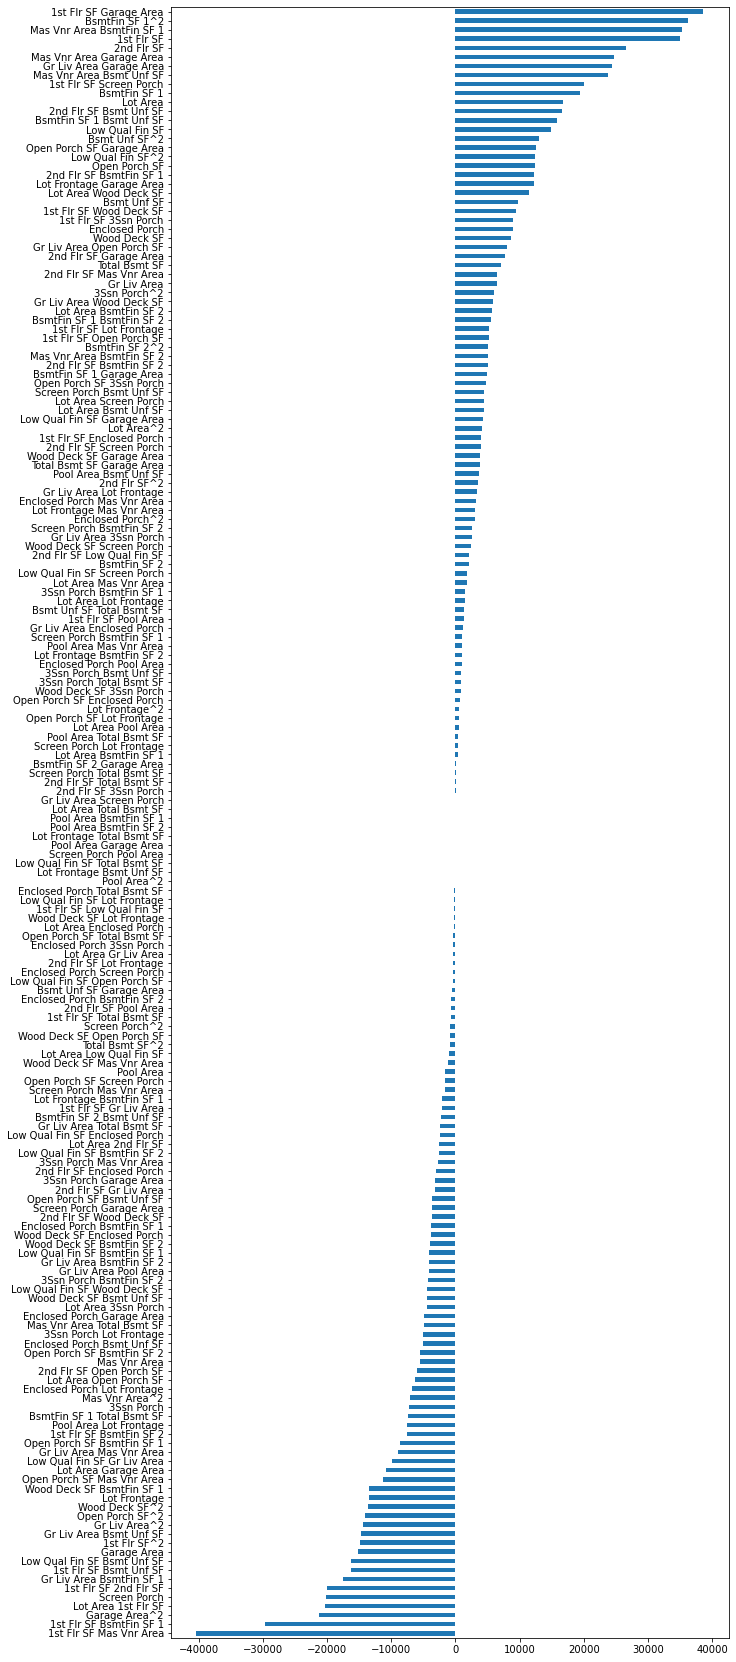

In [80]:
lasso_coefs = lasso_cv_v1.coef_
lasso_coefs = pd.Series(lasso_coefs, poly.get_feature_names(X_lari1.columns))

plt.figure(figsize=(10,30))
lasso_coefs[lasso_coefs != 0].sort_values().plot.barh();

In [81]:
lasso_coefs.sort_values().head(5)

1st Flr SF Mas Vnr Area   -40373.359151
1st Flr SF BsmtFin SF 1   -29585.395494
Garage Area^2             -21297.270030
Lot Area 1st Flr SF       -20262.569656
Screen Porch              -20126.260512
dtype: float64

In [82]:
lasso_coefs.sort_values().tail(5)

2nd Flr SF                   26596.137485
1st Flr SF                   35051.014765
Mas Vnr Area BsmtFin SF 1    35345.789821
BsmtFin SF 1^2               36214.475108
1st Flr SF Garage Area       38660.443618
dtype: float64

LASSO does about the same as the Ridge did, so for these features here I will not be looking at them much closer.


What the LASSO confirms is that for the most part, the top correlated features have the strongest impact on the model. The variables I am going to look more at are '1st Flr SF', 'Mas Vnr Area', 'BsmtFin SF 1', 'Garage Area', 'Lot Area', '2nd Flr SF', 'Gr Liv Area', 'Total Bsmt SF', and 'Screen Porch'. I'll be dropping the rest of the columns from features.

In [83]:
feat_v3 = feat_v3.drop(columns=['Low Qual Fin SF', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch',
                      '3Ssn Porch', 'Pool Area', 'Lot Frontage', 'BsmtFin SF 2', 'Bsmt Unf SF'])

In [84]:
feat_v3.head()

,Id,Lot Area,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,...,Misc Val,Year Built Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
0,109,13517,6,8,725,754,1479,2,1,3,...,0,3961880,289.0,533.0,725.0,0.0,0.0,1976.0,2.0,475.0
1,544,11492,7,5,913,1209,2122,2,1,4,...,0,3986012,132.0,637.0,913.0,1.0,0.0,1997.0,2.0,559.0
2,153,7922,5,7,1057,0,1057,1,0,3,...,0,3919671,0.0,731.0,1057.0,1.0,0.0,1953.0,1.0,246.0
3,318,9802,5,5,744,700,1444,2,1,3,...,0,4026042,0.0,0.0,384.0,0.0,0.0,2007.0,2.0,400.0
4,255,14235,6,8,831,614,1445,2,0,3,...,0,3786700,0.0,0.0,676.0,0.0,0.0,1957.0,2.0,484.0


In [85]:
feat_v3_sqft_cols = [ '1st Flr SF', 'Mas Vnr Area', 'BsmtFin SF 1',
                     'Garage Area', 'Lot Area', '2nd Flr SF', 'Gr Liv Area',
                     'Total Bsmt SF', 'Screen Porch']

In [86]:
sqft_corr = df_train_v3[feat_v3_sqft_cols + ['SalePrice']].corr()

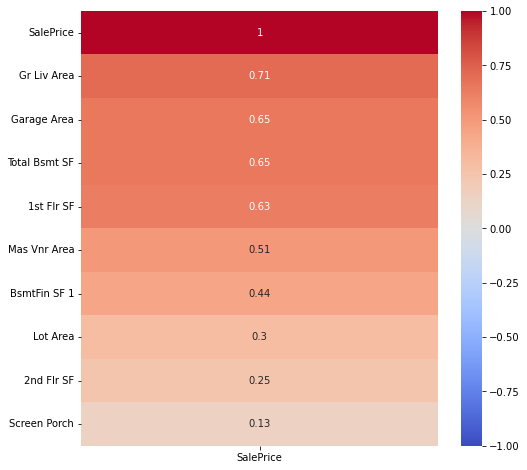

In [87]:
plt.figure(figsize=(8,8))
sns.heatmap(sqft_corr.sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

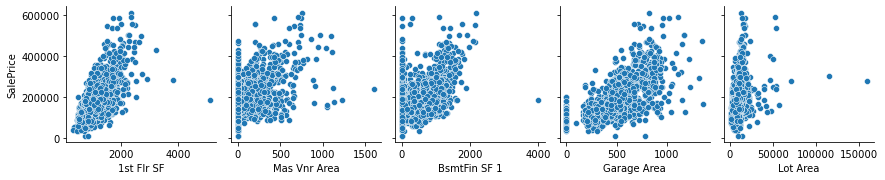

In [88]:
sns.pairplot(df_train_v3, x_vars=feat_v3_sqft_cols[:5], y_vars='SalePrice');

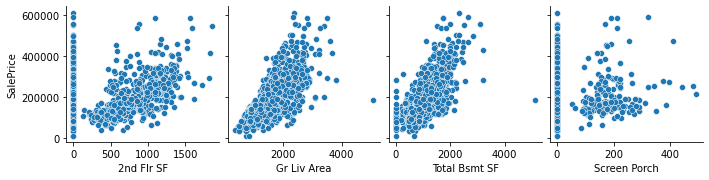

In [89]:
sns.pairplot(df_train_v3, x_vars=feat_v3_sqft_cols[5:], y_vars='SalePrice');

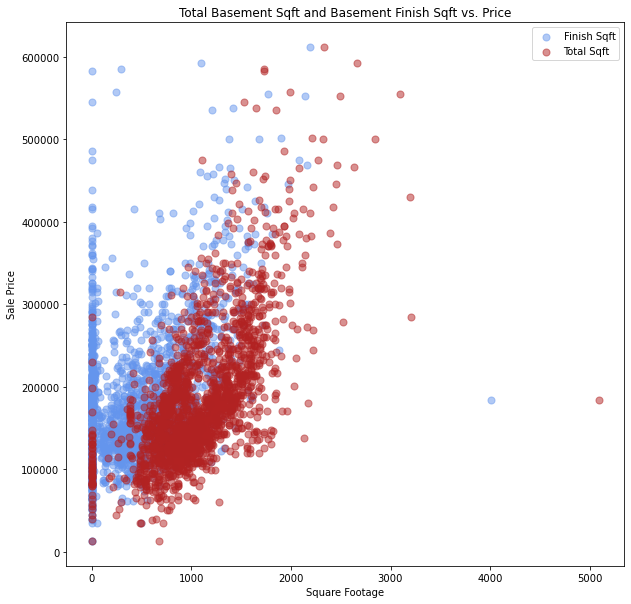

In [90]:
plt.figure(figsize=(10,10))
plt.scatter(df_train_v3['BsmtFin SF 1'], df_train_v3['SalePrice'], color='cornflowerblue', alpha=.5, s=50, label='Finish Sqft')
plt.scatter(df_train_v3['Total Bsmt SF'], df_train_v3['SalePrice'], color='firebrick', alpha=.5, s=50, label='Total Sqft')
plt.title('Total Basement Sqft and Basement Finish Sqft vs. Price')
plt.xlabel('Square Footage')
plt.ylabel('Sale Price')
plt.legend();

When looking at the scatterplots above, there are a couple of things that really stand out. First is that 1st Flr SF has a pretty strong and tight bunching that to me looks stronger than the correlation coefficient suggests. Just having some masonry vaneer increases the price, though I would like to compare that to the dummies for exterior type to see what happens there. A big standout is that if you don't have a garage at all, the price doesn't look to go much above \$200,000, if at all. Screen porch in the linear model dosn't make much sense, so the LASSO model most likely added used a major correction on it to make it important. BsmtFin SF 1 and Total Bsmt SF have similar plots, so I am going to look at multiplying them and seeing if that has a higher correlation. I'll need to look at the Lot Area outliers to see what is going on with those.


Dropping Screen Porch from features.

In [91]:
feat_v3.drop(columns='Screen Porch', inplace=True)

In [92]:
with pd.option_context('display.max_columns', 90):
    display(df_train_v3[df_train_v3['Lot Area'] >= 50_000])
    
# As far as I can tell right now, there is not a unique combination that fits all 3.
# I am going to drop it as a feature to see if that improves the variance some. 

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Year Built Year Remod/Add
471,2116,906426060,50,RL,0.0,159000,1,NA,2,Low,AllPub,CulDSac,3,ClearCr,Norm,Norm,1Fam,1.5Fin,6,7,1958,2006,Gable,CompShg,Wd Sdng,HdBoard,BrkCmn,472.0,4,3,CBlock,4,3,4,3,697.0,1,0.0,747.0,1444.0,GasA,4,1,SBrkr,1444,700,0,2144,0.0,1.0,2,0,4,1,4,7,7,2,3,Attchd,1958.0,Fin,2.0,389.0,3,3,1.0,0,98,0,0,0,0,0,NA,Shed,500,6,2007,WD,277000,3927748
694,2072,905301050,20,RL,0.0,115149,1,NA,2,Low,AllPub,CulDSac,3,ClearCr,Norm,Norm,1Fam,1Story,7,5,1971,2002,Gable,CompShg,Plywood,Plywood,Stone,351.0,3,3,CBlock,4,3,4,6,1219.0,1,0.0,424.0,1643.0,GasA,3,1,SBrkr,1824,0,0,1824,1.0,0.0,2,0,2,1,4,5,7,2,3,Attchd,1971.0,Unf,2.0,739.0,3,3,1.0,380,48,0,0,0,0,0,NA,NA,0,6,2007,WD,302000,3945942
745,315,916125360,20,RL,0.0,57200,1,NA,1,Bnk,AllPub,Inside,3,Timber,Norm,Norm,1Fam,1Story,5,5,1948,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,3,3,CBlock,3,3,3,4,353.0,3,334.0,60.0,747.0,GasA,3,1,SBrkr,1687,0,0,1687,1.0,0.0,1,0,3,1,3,7,6,2,3,Detchd,1966.0,Unf,2.0,572.0,3,3,0.0,0,0,50,0,0,0,0,NA,NA,0,6,2010,WD,160000,3798600
823,16,527216070,60,RL,47.0,53504,1,NA,2,HLS,AllPub,CulDSac,2,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,5,3,PConc,4,3,4,5,1416.0,1,0.0,234.0,1650.0,GasA,5,1,SBrkr,1690,1589,0,3279,1.0,0.0,3,1,4,1,5,12,4,1,4,BuiltIn,2003.0,Fin,3.0,841.0,3,3,1.0,503,36,0,0,210,0,0,NA,NA,0,6,2010,WD,538000,4012009
1052,1403,905401060,20,RL,0.0,53227,1,NA,1,Low,AllPub,CulDSac,2,ClearCr,Norm,Norm,1Fam,1Story,4,6,1954,1994,Flat,Tar&Grv,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,4,1116.0,1,0.0,248.0,1364.0,GasA,5,1,SBrkr,1663,0,0,1663,1.0,0.0,1,0,2,1,4,6,6,2,4,Attchd,1954.0,Fin,2.0,529.0,3,3,1.0,224,137,0,0,0,0,0,NA,NA,0,3,2008,WD,256000,3896276
1571,2523,533350050,20,RL,68.0,50271,1,NA,1,Low,AllPub,Inside,1,Veenker,Norm,Norm,1Fam,1Story,9,5,1981,1987,Gable,WdShngl,WdShing,Wd Shng,None,0.0,4,3,CBlock,5,3,4,6,1810.0,1,0.0,32.0,1842.0,GasA,4,1,SBrkr,1842,0,0,1842,2.0,0.0,0,1,0,1,4,5,7,1,4,Attchd,1981.0,Fin,3.0,894.0,3,3,1.0,857,72,0,0,0,0,0,NA,NA,0,11,2006,WD,385000,3936247
1726,2894,916325040,20,RL,0.0,50102,1,NA,1,Low,AllPub,Inside,2,Timber,Norm,Norm,1Fam,1Story,6,5,1958,1958,Gable,Tar&Grv,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,4,909.0,1,0.0,723.0,1632.0,GasA,3,1,SBrkr,1650,0,0,1650,1.0,0.0,1,0,2,1,3,6,7,2,4,Attchd,1958.0,Unf,2.0,518.0,3,3,1.0,0,0,0,0,138,0,0,NA,NA,0,3,2006,WD,250764,3833764
1843,2117,906426195,60,RL,0.0,53107,1,NA,2,Low,AllPub,Corner,2,ClearCr,Feedr,Norm,1Fam,2Story,6,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,4,3,PConc,4,3,3,6,985.0,1,0.0,595.0,1580.0,GasA,5,1,SBrkr,1079,874,0,1953,1.0,0.0,2,1,3,1,4,9,7,2,2,Attchd,1992.0,Fin,2.0,501.0,3,3,1.0,216,231,0,0,0,0,0,NA,NA,0,6,2007,WD,240000,3968064
1854,2767,906475200,20,RL,62.0,70761,1,NA,1,Low,AllPub,Inside,2,ClearCr,Norm,Norm,1Fam,1Story,7,5,1975,1975,Gable,WdShngl,Plywood,Plywood,None,0.0,3,3,CBlock,4,3,4,5,655.0,1,0.0,878.0,1533.0,GasA,3,1,SBrkr,1533,0,0,1533,1.0,0.0,2,0,2,1,4,5,7,2,3,Attchd,1975.0,Unf,2.0,576.0,3,3,1.0,200,54,0,0,0,0,0,NA,NA,0,12,2006,WD,280000,3900625
1964,1638,527216080,20,RL,52.0,51974,

In [93]:
# Bsmt and bsmt fin feature
df_train_v3['Bsmt SF BsmtFin SF 1'] = df_train_v3['Total Bsmt SF'] * df_train_v3['BsmtFin SF 1']

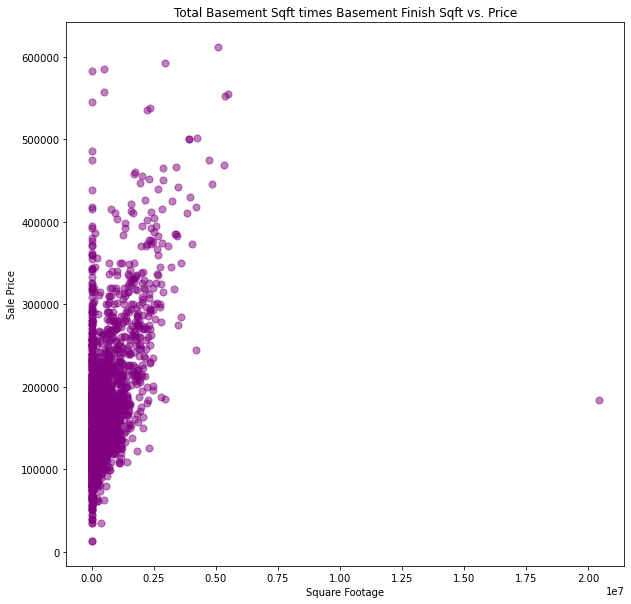

In [94]:
plt.figure(figsize=(10,10))
plt.scatter(df_train_v3['Bsmt SF BsmtFin SF 1'], df_train_v3['SalePrice'], color='purple', alpha=.5, s=50)
plt.title('Total Basement Sqft times Basement Finish Sqft vs. Price')
plt.xlabel('Square Footage')
plt.ylabel('Sale Price');

In [95]:
with pd.option_context('display.max_columns', 90):
    display(df_train_v3[df_train_v3['Bsmt SF BsmtFin SF 1']>20_000_000])
# This is the one outlier that has both the largest basement and largest finished sqft, but also a rather low sales price.

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,Year Built Year Remod/Add,Bsmt SF BsmtFin SF 1
1885,2181,908154195,20,RL,128.0,39290,1,NA,1,Bnk,AllPub,Inside,1,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224.0,5,3,PConc,5,3,4,6,4010.0,1,0.0,1085.0,5095.0,GasA,5,1,SBrkr,5095,0,0,5095,1.0,1.0,2,1,2,1,5,15,7,2,4,Attchd,2008.0,Fin,3.0,1154.0,3,3,1.0,546,484,0,0,0,0,0,NA,Elev,17000,10,2007,New,183850,4034072,20430950.0


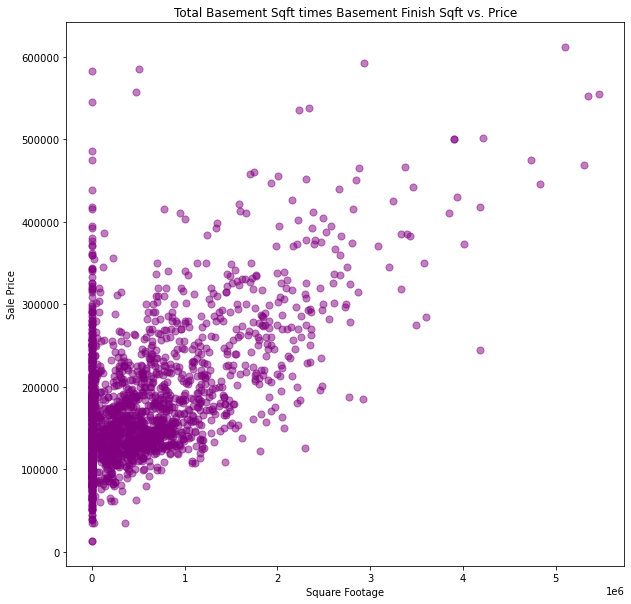

In [96]:
plt.figure(figsize=(10,10))
plt.scatter(df_train_v3['Bsmt SF BsmtFin SF 1'].drop(1885), df_train_v3['SalePrice'].drop(1885), 
            color='purple', alpha=.5, s=50, label='Combined')
plt.title('Total Basement Sqft times Basement Finish Sqft vs. Price')
plt.xlabel('Square Footage')
plt.ylabel('Sale Price');

In [97]:
df_train_v3[['Bsmt SF BsmtFin SF 1', 'SalePrice']].corr()

,Bsmt SF BsmtFin SF 1,SalePrice
Bsmt SF BsmtFin SF 1,1.000000,0.491811
SalePrice,0.491811,1.000000


The correlation is actually weaker than just having total basement squarefootage, thus I won't use it. I am also going to drop Basement Finish from the features.


I am dropping index 1885, Id number 2181, because it has the largest outlier in terms of basement and the price is very low comparatively that I can't correct for.

In [98]:
df_train_v3.drop(columns='Bsmt SF BsmtFin SF 1', inplace=True)

In [99]:
df_train_v3.drop(1885, inplace=True)

In [100]:
df_train_v3.shape

(2049, 82)

In [101]:
feat_v3.drop(columns=['BsmtFin SF 1', 'Lot Area'], inplace=True)

In [102]:
feat_v3.shape

(2050, 21)

In [103]:
X_v3 = df_train_v3[feat_v3.drop(columns='Id').columns]
y_v3 = df_train_v3['SalePrice']

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, random_state=2010)

lr_v3= LinearRegression()
lr_v3.fit(X_train_v3, y_train_v3)

LinearRegression()

In [104]:
lr_v3.score(X_train_v3, y_train_v3)

0.866699221560731

In [105]:
lr_v3.score(X_test_v3, y_test_v3)

0.8420477927914731

In [106]:
cross_val_score(lr_v3, X_test_v3, y_test_v3).mean()

0.8421031416482337

This new model appears to be doing much better than the other models so far. I increased the cross val score from the mid 70s to 84 on this last model, and the training and test scores about two points each.

In [107]:
feat_v3.head()

,Id,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,...,Fireplaces,Misc Val,Year Built Year Remod/Add,Mas Vnr Area,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath,Garage Yr Blt,Garage Cars,Garage Area
0,109,6,8,725,754,1479,2,1,3,1,...,0,0,3961880,289.0,725.0,0.0,0.0,1976.0,2.0,475.0
1,544,7,5,913,1209,2122,2,1,4,1,...,1,0,3986012,132.0,913.0,1.0,0.0,1997.0,2.0,559.0
2,153,5,7,1057,0,1057,1,0,3,1,...,0,0,3919671,0.0,1057.0,1.0,0.0,1953.0,1.0,246.0
3,318,5,5,744,700,1444,2,1,3,1,...,0,0,4026042,0.0,384.0,0.0,0.0,2007.0,2.0,400.0
4,255,6,8,831,614,1445,2,0,3,1,...,0,0,3786700,0.0,676.0,0.0,0.0,1957.0,2.0,484.0


In [108]:
# Export feats_v3 without Id to 03 for kaggle
feat_v3.drop(columns='Id').to_csv('../datasets/ready_for_model/feat_v3.csv', index=False)
df_train_v3.to_csv('../datasets/ready_for_model/clean_train_v3.csv', index=False)

Switching focus to room counts, fireplaces, and cars.

In [109]:
feat_v3.columns

Index(['Id', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Misc Val',
       'Year Built Year Remod/Add', 'Mas Vnr Area', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars',
       'Garage Area'],
      dtype='object')

In [110]:
feat_v3_room_counts = ['Full Bath', 'Half Bath', 'Bedroom AbvGr',
                       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
                       'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars',]

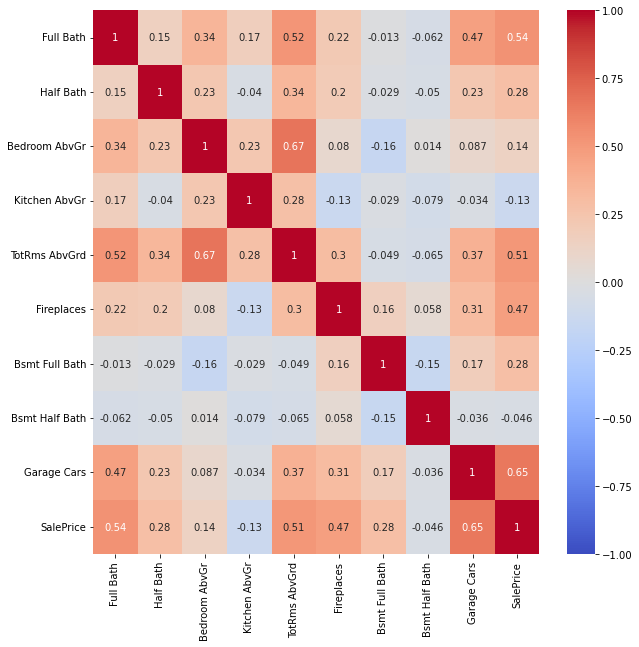

In [111]:
plt.figure(figsize=(10,10))
sns.heatmap(df_train_v3[feat_v3_room_counts+['SalePrice']].corr(),
            vmin=-1, vmax=1, annot=True, cmap='coolwarm');

Some quick notes on the above heatmap. Garage cars and garage area have the same coefficient (0.65) when compared to sales price. I am going to compare all 3 garage statistics below. Interestingly, having more bedrooms doesn't affect sale price as much as bathrooms do. Total rooms is surprisingly not the highest correlated, being second to full baths. Total rooms and bedrooms and total rooms and full baths have a high correlations together, so I want to multiply them and see if that makes a bigger difference. Conversely, beds and baths have the largest, albeit still small, relationship, so I want to see what making a column with those two values will due. 


I will be dropping Basement Half Baths since all correlations are basically 0.

In [112]:
df_train_v3['tot_room_tot_bed'] = df_train_v3['TotRms AbvGrd'] * df_train_v3['Bedroom AbvGr']
df_train_v3['tot_room_full_bath'] = df_train_v3['TotRms AbvGrd'] * df_train_v3['Full Bath']
df_train_v3['bed_full_bath'] = df_train_v3['Bedroom AbvGr'] * df_train_v3['Full Bath']

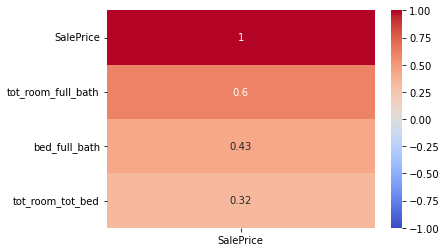

In [113]:
sns.heatmap(df_train_v3[['tot_room_tot_bed', 'tot_room_full_bath', 'bed_full_bath', 'SalePrice']].corr().sort_values('SalePrice', ascending=False)[['SalePrice']],
           vmin=-1, vmax=1, annot=True, cmap='coolwarm');

I think I will use the bed_ful_bath feature as it does have more of an affect than bedrooms alone, and full baths is counted in total rooms, which are close together in correlation. Thus I will drop 'Full Bath' and 'Bedroom AbvGr' from features and add 'bed_full_bath' to features.

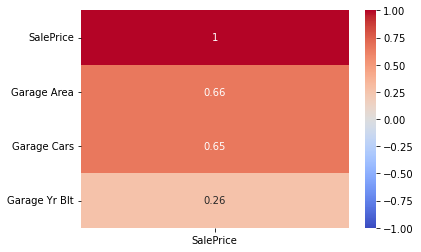

In [114]:
sns.heatmap(df_train_v3[['SalePrice','Garage Cars', 'Garage Area', 'Garage Yr Blt']].corr().sort_values('SalePrice', ascending=False)[['SalePrice']],
            vmin=-1, vmax=1, annot=True, cmap='coolwarm');

This quick correlation heatmap shows that the year the garage was built doesn't matter as much as just having the garage period. Thus I am dropping the Garage Yr Built and Garage Cars from the features list. 

In [115]:
feat_v3.drop(columns=['Garage Yr Blt', 'Garage Cars', 'Bsmt Half Bath', 'Full Bath', 'Bedroom AbvGr'], inplace=True)

In [116]:
feat_v3 = pd.merge(feat_v3, df_train_v3[['Id', 'bed_full_bath']], on='Id', how='left')

In [117]:
feat_v3.head()

,Id,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Gr Liv Area,Half Bath,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Misc Val,Year Built Year Remod/Add,Mas Vnr Area,Total Bsmt SF,Bsmt Full Bath,Garage Area,bed_full_bath
0,109,6,8,725,754,1479,1,1,6,0,0,3961880,289.0,725.0,0.0,475.0,6.0
1,544,7,5,913,1209,2122,1,1,8,1,0,3986012,132.0,913.0,1.0,559.0,8.0
2,153,5,7,1057,0,1057,0,1,5,0,0,3919671,0.0,1057.0,1.0,246.0,3.0
3,318,5,5,744,700,1444,1,1,7,0,0,4026042,0.0,384.0,0.0,400.0,6.0
4,255,6,8,831,614,1445,0,1,6,0,0,3786700,0.0,676.0,0.0,484.0,6.0


In [118]:
# drop tot_room_bed, tot_room_bath from df_train_v3
df_train_v3.drop(columns=['tot_room_full_bath', 'tot_room_tot_bed'], inplace=True)

In [119]:
X_v3 = df_train_v3[feat_v3.drop(columns='Id').columns]
y_v3 = df_train_v3['SalePrice']

X_train_v3, X_test_v3, y_train_v3, y_test_v3 = train_test_split(X_v3, y_v3, random_state=2010)

lr_v3.fit(X_train_v3, y_train_v3)

LinearRegression()

In [120]:
lr_v3.score(X_train_v3, y_train_v3)

0.8597341362715942

In [121]:
lr_v3.score(X_test_v3, y_test_v3)

0.8390663498913855

In [122]:
cross_val_score(lr_v3, X_train_v3, y_train_v3).mean()

0.8543333407840006

There is a little more bias in the training score, but the variance is down a little bit between the training score and the test score. However, the cross val score is closer to the training score but unfortunately further from the test score. Still going to submit and see how it does in Kaggle. 

In [123]:
feat_v3.drop(columns='Id').to_csv('../datasets/ready_for_model/feat_v3_1.csv', index=False)
df_train_v3.to_csv('../datasets/ready_for_model/clean_train_v3_1.csv', index=False)

In [124]:
preds_v3 = lr_v3.predict(X_test_v3)
residuals_v3 = y_test_v3 - preds_v3

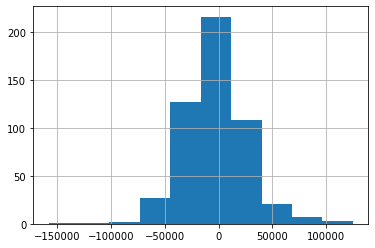

In [125]:
residuals_v3.hist();
# Should look at the residuals that are greater than 100,000 and less than -100,000

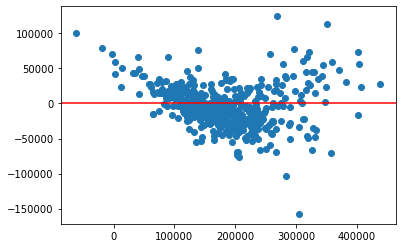

In [126]:
plt.scatter(preds_v3, residuals_v3)
plt.axhline(0, color='r');

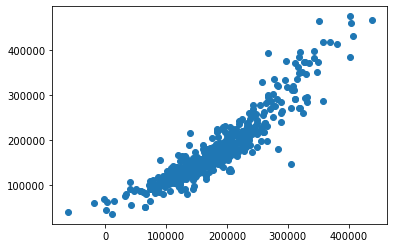

In [127]:
plt.scatter(preds_v3, y_test_v3);

Looking at the residuals and predictions, the model is starting to look less like a Nike swoosh and a little more regular. There are also fewer residual outliers to look at. I am going to finish working on the numeric features before addressing the residuals more. 

#### Model 4 
I will be adding in the object columns that were turned into numeric.

In [128]:
# import dataframe
obj_to_num = pd.read_csv('../datasets/cleaned_data/obj_to_num.csv')
obj_to_num.columns

Index(['Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC'],
      dtype='object')

In [129]:
df_train_v4 = df_train_v3
# Switching to version 4 for this section

In [130]:
feat_v4 = pd.merge(feat_v3, df_train_v4[['Id','Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC']], on='Id', how='left')

feat_v4.head()

,Id,Overall Qual,Overall Cond,1st Flr SF,2nd Flr SF,Gr Liv Area,Half Bath,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,...,BsmtFin Type 2,Heating QC,Central Air,Kitchen Qual,Functional,Fireplace Qu,Garage Qual,Garage Cond,Paved Drive,Pool QC
0,109,6,8,725,754,1479,1,1,6,0,...,1.0,5.0,1.0,4.0,7.0,0.0,3.0,3.0,1.0,0.0
1,544,7,5,913,1209,2122,1,1,8,1,...,1.0,5.0,1.0,4.0,7.0,3.0,3.0,3.0,1.0,0.0
2,153,5,7,1057,0,1057,0,1,5,0,...,1.0,3.0,1.0,4.0,7.0,0.0,3.0,3.0,1.0,0.0
3,318,5,5,744,700,1444,1,1,7,0,...,1.0,4.0,1.0,3.0,7.0,0.0,3.0,3.0,1.0,0.0
4,255,6,8,831,614,1445,0,1,6,0,...,1.0,3.0,1.0,3.0,7.0,0.0,3.0,3.0,0.0,0.0


Since these new columns are all scales, I want to run it as is now to see how this looks and submit a version to Kaggle. 

In [131]:
# Train_test & Evaluate
X_v4 = df_train_v4[feat_v4.columns].drop(columns='Id')
y_v4 = df_train_v4['SalePrice']

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(X_v4, y_v4, random_state=2010)

lr_v4 = LinearRegression()
lr_v4.fit(X_train_v4, y_train_v4)

LinearRegression()

In [132]:
lr_v4.score(X_train_v4, y_train_v4)

0.8842042679543811

In [133]:
lr_v4.score(X_test_v4, y_test_v4)

0.8679292179288004

In [134]:
cross_val_score(lr_v4, X_train_v4, y_train_v4).mean()

0.874974265623567

The test scores are better across the board and the variance is down. The difference between test score and cross val is down to less than 1% and the difference between training and test scores is less than 2%.

In [135]:
feat_v4.drop(columns='Id').to_csv('../datasets/ready_for_model/feat_v4.csv', index=False)
df_train_v4.to_csv('../datasets/ready_for_model/clean_train_v4.csv', index=False)

This model has put me under 30,000 on Kaggle for the first time. I'm going to look at the plots for all the features and then I  want to multiply all quality and condition pairs to see how that effects the model. For example, overall quality times overall condition. 

In [136]:
feat_v4.columns

Index(['Id', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Misc Val', 'Year Built Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Garage Area', 'bed_full_bath',
       'Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC'],
      dtype='object')

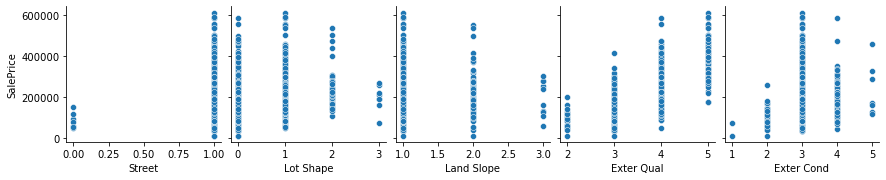

In [137]:
sns.pairplot(df_train_v4, 
             x_vars=['Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond'], 
             y_vars='SalePrice');
# What's interesting is that the gravel roads do have a much lower sale price. Land slope has a minimal looking effect.
# External condition doesn't have as linear an effect as External Quality

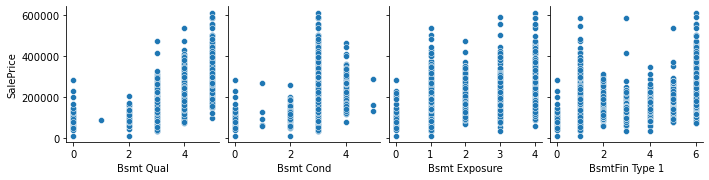

In [138]:
sns.pairplot(df_train_v4, 
             x_vars=['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1'], 
             y_vars='SalePrice');
# Basement Quality is a good one to use, while condition is questionable. Exposure is pretty level
# Finish type 1 is odd. Will need to look at that more.

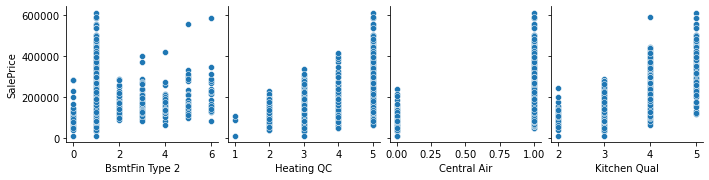

In [139]:
sns.pairplot(df_train_v4, 
             x_vars=['BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual'], 
             y_vars='SalePrice');
# Heating QC is one to look closer at, along with Central Air. Kitchen Quality also looks important, despite number of
# kitchens not being that important.

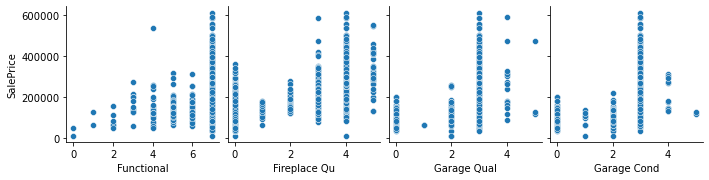

In [140]:
sns.pairplot(df_train_v4, 
             x_vars=['Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond'], 
             y_vars='SalePrice');
# Functionality probably would go good with overall qual and cond. 
# Garage Qual and Cond are pretty similar, so may only need one. 

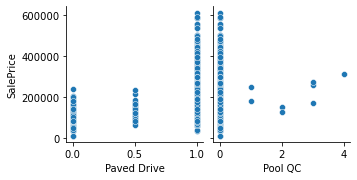

In [141]:
sns.pairplot(df_train_v4, 
             x_vars=['Paved Drive', 'Pool QC'], 
             y_vars='SalePrice');
# Paved Driveways are a bigger deal than I thought. 
# Pool qual is interesting because the ones with pools aren't that expensive comparatively.

In [142]:
obj_num_feat_corr = df_train_v4[['Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC', 'SalePrice']].corr()

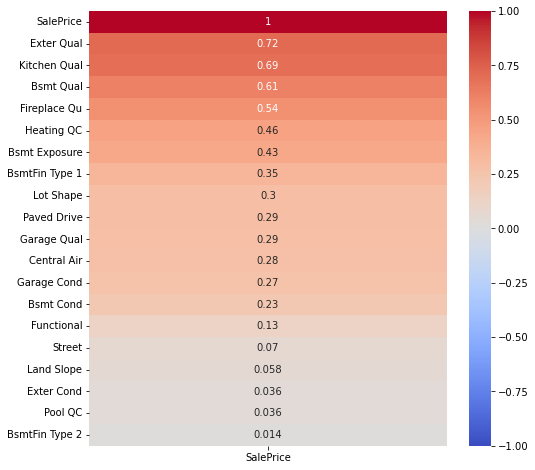

In [143]:
plt.figure(figsize=(8,8))
sns.heatmap(obj_num_feat_corr.sort_values('SalePrice', ascending=False)[['SalePrice']],
            vmin=-1, vmax=1, annot=True, cmap='coolwarm');

For the most part, this heatmap confirms what I saw in the scatter plots. Even though the correlations aren't strong, I'm keeping in the 'Street' and 'Pool QC' because even though there aren't many houses with these features differing from the rest, they still have an impact based on the scatter plot. I'm going to combine the various features that look like they go together to see how they behave.  

In [144]:
df_train_v4['overall_qual_cond'] = df_train_v4['Overall Qual'] * df_train_v4['Overall Cond']
df_train_v4['exter_qual_cond'] = df_train_v4['Exter Qual'] * df_train_v4['Exter Cond']
df_train_v4['bsmt_qual_cond'] = df_train_v4['Bsmt Qual'] * df_train_v4['Bsmt Cond']
df_train_v4['garage_qual_cond'] = df_train_v4['Garage Qual'] * df_train_v4['Garage Cond']

In [145]:
df_train_v4['mas_vnr_ext_qual_cond'] = df_train_v4['Mas Vnr Area'] * df_train_v4['Exter Qual'] * df_train_v4['Exter Cond']
df_train_v4['bsmt_sf_qual_cond'] = df_train_v4['Total Bsmt SF'] * df_train_v4['bsmt_qual_cond']
df_train_v4['garage_area_qual_cond'] = df_train_v4['Garage Area'] * df_train_v4['garage_qual_cond']
df_train_v4['lot_shape_land_slope'] = df_train_v4['Lot Shape'] * df_train_v4['Land Slope']
df_train_v4['bsmt_exposure_qual'] = df_train_v4['Bsmt Exposure'] * df_train_v4['Bsmt Qual']
df_train_v4['tot_fire_qu'] = df_train_v4['Fireplaces'] * df_train_v4['Fireplace Qu']

In [146]:
feat_v4_combos = df_train_v4[['Id', 'overall_qual_cond', 'exter_qual_cond', 'bsmt_qual_cond',
                              'garage_qual_cond', 'mas_vnr_ext_qual_cond', 'bsmt_sf_qual_cond', 'garage_area_qual_cond',
                             'lot_shape_land_slope', 'bsmt_exposure_qual', 'tot_fire_qu', 'SalePrice']]

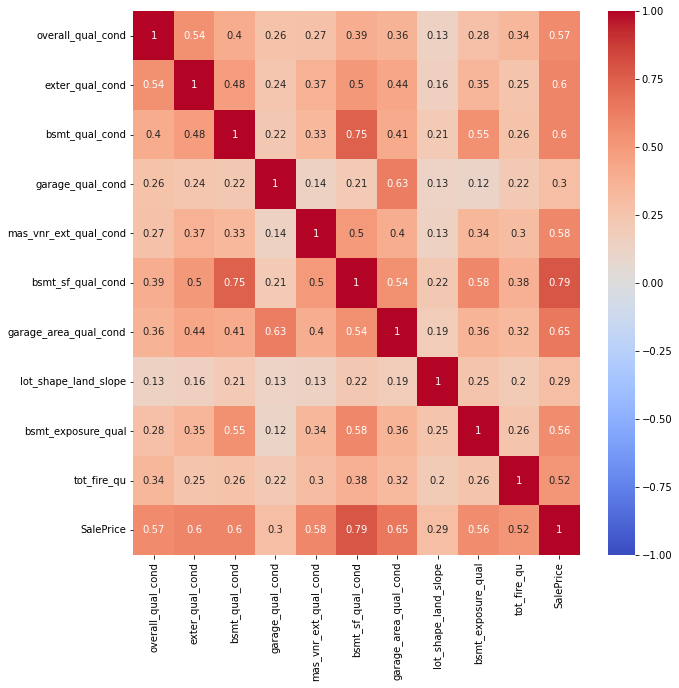

In [147]:
plt.figure(figsize=(10,10))
sns.heatmap(feat_v4_combos.drop(columns='Id').corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm');

Lot shape and land slope combo does not seem to add much. I think everything else looks like it is an improvement. I am going to add all but the 'lot_shape_land_slope' and 'garage_qual_cond' to the features. I am going to run a test with all the base features included and then one without them and see what works best. 

In [148]:
feat_v4 = pd.merge(feat_v4, df_train_v4[feat_v4_combos.columns].drop(columns=['SalePrice', 'lot_shape_land_slope', 'garage_qual_cond']),
        on='Id', how='left')

In [149]:
feat_v4.drop(columns='Id').columns

Index(['Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Misc Val', 'Year Built Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Garage Area', 'bed_full_bath',
       'Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC', 'overall_qual_cond', 'exter_qual_cond',
       'bsmt_qual_cond', 'mas_vnr_ext_qual_cond', 'bsmt_sf_qual_cond',
       'garage_area_qual_cond', 'bsmt_exposure_qual', 'tot_fire_qu'],
      dtype='object')

In [150]:
X_v4 = df_train_v4[feat_v4.columns].drop(columns='Id')
y_v4 = df_train_v4['SalePrice']

X_train_v4, X_test_v4, y_train_v4, y_test_v4 = train_test_split(X_v4, y_v4, random_state=2010)

lr_v4.fit(X_train_v4, y_train_v4)

LinearRegression()

In [151]:
lr_v4.score(X_train_v4, y_train_v4)

0.9119371262543756

In [152]:
lr_v4.score(X_test_v4, y_test_v4)

0.8929066806377044

In [153]:
cross_val_score(lr_v4, X_train_v4, y_train_v4).mean()

0.9011129947603328

Definitely better in terms of bias. The variance remains rather steady, but still on the smaller side. I am running the same thing below and dropping the base features to see how that performs. 

In [154]:
X_v4_1 = df_train_v4[feat_v4.columns].drop(columns=['Id', 'Overall Qual', 'Overall Cond', 'Exter Qual',
                                                    'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Garage Qual',
                                                   'Garage Cond', 'Mas Vnr Area', 'Total Bsmt SF', 'Garage Area',
                                                   'Bsmt Exposure', 'Fireplaces', 'Fireplace Qu'])
y_v4_1 = df_train_v4['SalePrice']

X_train_v4_1, X_test_v4_1, y_train_v4_1, y_test_v4_1 = train_test_split(X_v4_1, y_v4_1, random_state=2010)

lr_v4_1=LinearRegression()
lr_v4_1.fit(X_train_v4_1, y_train_v4_1)

LinearRegression()

In [155]:
lr_v4_1.score(X_train_v4_1, y_train_v4_1)

0.8993283413750616

In [156]:
lr_v4_1.score(X_test_v4_1, y_test_v4_1)

0.8796679972773546

In [157]:
cross_val_score(lr_v4_1, X_train_v4_1, y_train_v4_1).mean()

0.8917869365489122

This version (4_1) is a little worse than the version 4, thus I will stick with version 4 and use it to submit some predictions to Kaggle.

In [158]:
df_train_v4.drop(columns=['lot_shape_land_slope', 'garage_qual_cond'], inplace=True)

In [159]:
feat_v4.drop(columns='Id').to_csv('../datasets/ready_for_model/feat_v4_1.csv', index=False)
df_train_v4.to_csv('../datasets/ready_for_model/clean_train_v4_1.csv', index=False)

The last thing I am going to do with the numeric only columns is to look at the correlations one last time and see if there is anything that could be dropped and then run a test without those columns.

In [160]:
feat_v4.columns

Index(['Id', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Misc Val', 'Year Built Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Garage Area', 'bed_full_bath',
       'Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC', 'overall_qual_cond', 'exter_qual_cond',
       'bsmt_qual_cond', 'mas_vnr_ext_qual_cond', 'bsmt_sf_qual_cond',
       'garage_area_qual_cond', 'bsmt_exposure_qual', 'tot_fire_qu'],
      dtype='object')

In [161]:
num_semifinal_cols = ['Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Misc Val', 'Year Built Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Garage Area', 'bed_full_bath',
       'Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC', 'overall_qual_cond', 'exter_qual_cond',
       'bsmt_qual_cond', 'mas_vnr_ext_qual_cond', 'bsmt_sf_qual_cond',
       'garage_area_qual_cond', 'bsmt_exposure_qual', 'tot_fire_qu', 'SalePrice']

In [162]:
num_col_corr = df_train_v4[num_semifinal_cols].corr()

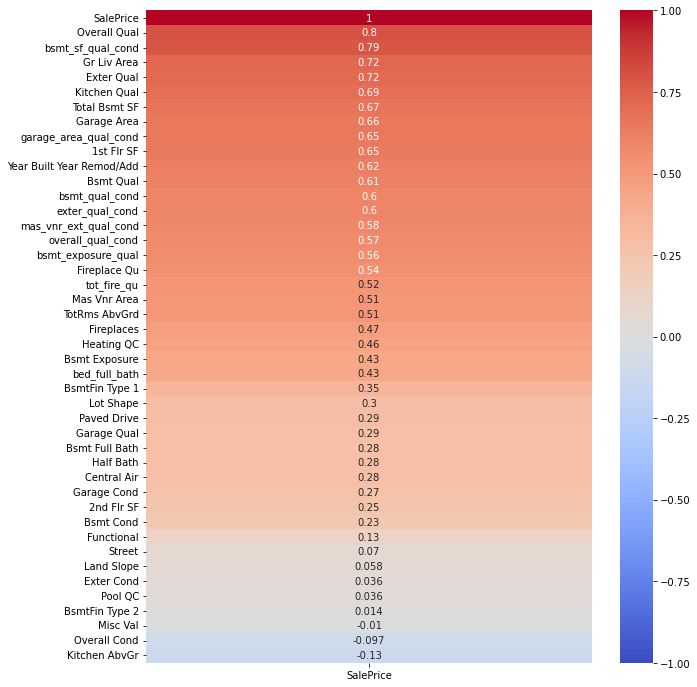

In [163]:
plt.figure(figsize=(10,12))
sns.heatmap(num_col_corr.sort_values('SalePrice', ascending=False)[['SalePrice']],
            vmin=-1, vmax=1, annot=True, cmap='coolwarm');

I am going to remove anything that is grey to test and see what the new model will predict, and see if this will help the variance at all. 

In [164]:
X_v4_1 = df_train_v4[num_semifinal_cols].drop(columns=['Street', 'Land Slope', 'Exter Cond', 'Pool QC', 
                                                       'BsmtFin Type 2', 'Misc Val', 'SalePrice'])
y_v4_1 = df_train_v4['SalePrice']

X_train_v4_1, X_test_v4_1, y_train_v4_1, y_test_v4_1 = train_test_split(X_v4_1, y_v4_1, random_state=2010)

lr_v4_1=LinearRegression()
lr_v4_1.fit(X_train_v4_1, y_train_v4_1)

LinearRegression()

In [165]:
lr_v4_1.score(X_train_v4_1, y_train_v4_1)

0.911179879114972

In [166]:
lr_v4_1.score(X_test_v4_1, y_test_v4_1)

0.8932292799146397

In [167]:
cross_val_score(lr_v4_1, X_train_v4_1, y_train_v4_1).mean()

0.9019574907565415

Compared to the other models, this one is slightly more balanced, but just barely. I am going to submit it to Kaggle and determine my best numeric model based on that score. 

In [168]:
feat_v4.drop(columns=['Street', 'Land Slope', 'Exter Cond', 'Pool QC', 'BsmtFin Type 2', 'Misc Val','Id']).to_csv('../datasets/ready_for_model/feat_v4_2.csv', index=False)

I am going to use the model above this one to generate predictions and look at residuals to see what I can improve on.

In [169]:
preds_v4 = lr_v4.predict(X_test_v4)
residuals_v4 = y_test_v4 - preds_v4

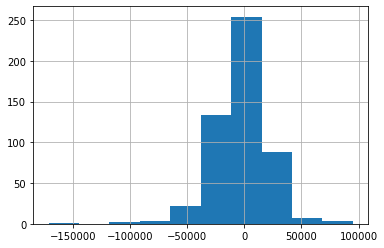

In [170]:
residuals_v4.hist();

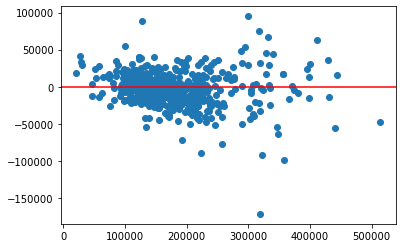

In [171]:
plt.scatter(preds_v4, residuals_v4)
plt.axhline(0, color='r');

These charts are looking much better. The spread is starting to look more homoskedastic, but still spreads out towards the end once the predictions go above \$300,000. I have decided that it will be best to address the outliers once the dummies have been added in because some of the dummies may correct some of the outliers. 

In [172]:
df_train_v4[feat_v4.columns].to_csv('../datasets/cleaned_data/feat_num_final.csv', index=False)
df_train_v4.to_csv('../datasets/cleaned_data/clean_train_v5.csv', index=False)

# Next Steps
Now that the testing is done, below are the numeric columns that I am keeping and combining with the dummies that are being generated in the 02.2 notebook. The combined models are in notebook 02.3. I am using the second to last model I submitted. The last two were close, but the second to last one performed just a little bit better. 

I am now moving into the 02.2_Object_EDA_and_Feat_Engineering notebook to make the dummy columns for some features and add them into the model. The updated models will still be staged in notebook 03 for submission. 

In [173]:
feat_v4.columns

Index(['Id', 'Overall Qual', 'Overall Cond', '1st Flr SF', '2nd Flr SF',
       'Gr Liv Area', 'Half Bath', 'Kitchen AbvGr', 'TotRms AbvGrd',
       'Fireplaces', 'Misc Val', 'Year Built Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', 'Bsmt Full Bath', 'Garage Area', 'bed_full_bath',
       'Street', 'Lot Shape', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Central Air', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Qual', 'Garage Cond',
       'Paved Drive', 'Pool QC', 'overall_qual_cond', 'exter_qual_cond',
       'bsmt_qual_cond', 'mas_vnr_ext_qual_cond', 'bsmt_sf_qual_cond',
       'garage_area_qual_cond', 'bsmt_exposure_qual', 'tot_fire_qu'],
      dtype='object')